# FHIR for Research Workshop - Exercise 3

## Learning Objectives and Key Concepts

In this exercise, you will 

- Apply Knowledge from Exercises 0, 1, and 2
- Attempt to complete each activity on your own individually
- Query active Prescriptions in our Patient cohort
- Understand the (non-FHIR) Drug-on-Drug Interaction API and learn how to query it
- Combine the FHIR data with the non-FHIR API to determine Drug-on-Drug Interactions.

## Drug on Drug Interactions
For this exercise we will explore potential drug on drug interactions in a sizable patient cohort stored in FHIR combined with drug interaction data from the NIH's Drug RxNAV database. 

## Motivation/Purpose
From a research persective we can envision leveraging these sorts of analyses to do post-market surveillance of drugs to determine both the rate of known adverse events among patients, as well as to potentially flag additional risks not yet identified. 

From a clinical perspective, this exercise demonstrates the ability for third-party data (in this case Drug on Drug interaction data), can be pulled in, paired with FHIR formatted clinical data, and then leveraged to better inform patient care in the form of Clinical Decision Support tools.

 ### Icons in this Guide
 📘 A link to a useful external reference related to the section the icon appears in  

 🖐 A hands-on section where you will code something or interact with the server  

## Step 1: Query all active prescriptions in our patient cohort
For this exercise we will call on the `MedicationRequest` which represents a medication prescription in FHIR.


📘[Read more about the MedicationRequest Resource](https://www.hl7.org/fhir/medicationrequest.html) 

Each `MedicationRequest` represents a single prescription, such that you have a many-to-one relationship of prescriptions to patients.

(This fact will be critical for our exercise, as determining a potential drug on drug interaction will require effectively grouping `MedicationRequest` resources by patient, to determine if the patient is on multiple concurrent prescriptions. We will therefore want to make sure we can include the relevant patient information to ensure we can map multiple prescriptions to individual patients.)

In [ ]:
# Python standard library API for dealing with json
import json
# For making HTTP requests to the FHIR server
import requests
# Python data analysis library
import pandas as pd

FHIR_SERVER = 'https://api.logicahealth.org/researchonfhir/open'

# Configure requests session with standard headers
s = requests.Session()
s.headers.update({'Accept':'application/fhir+json', 'Content-Type': 'application/fhir+json'})

# Optional: Turn off SSL verification. Useful when dealing with a corporate proxy with self-signed certificates.
s.verify = False
requests.packages.urllib3.disable_warnings()



### Compose the FHIR query
First compose a query to pull the 'MedicationRequest' resource from the FHIR server. Then convert it to JSON format. Optionally, you could output the resulting JSON file to confirm that you've successfully queried the database.

🖐 Fill in the URL to for retrieving `MedicationRequest` Resources

In [ ]:
r = s.get(f"{FHIR_SERVER}/FILLMEIN")
bundle = r.json()

We can now leverage the methods we deployed previously in Exercises 1 and 2 to create a python list which contains only the Bundle.entry.resource elements from the bundle returned in the previous step. 

As a first step let's leverage the list mapping lambda function we deployed in Exercise 2 Section 1.1 ([Link to Exercise 2 here](https://github.com/mitre/fhir-exercises/blob/main/Exercise_2_KidsFirst.ipynb) for reference) to map out our JSON file (entering the entire bundle, and mapping by resource) 

As a sanity test let's return the first resource item (index 0 or [0]) so we can get a better look at what information we have to work with.

🖐 Create a list of just the patient resources from the entries in the bundle

In [ ]:
prescriptions = # To be completed...
prescriptions[0]

### Convert Data onto a Pandas Dataframe

Now that we've confirmed that we've extracted information we need from our FHIR server, we will then take the FHIR formatted data and convert it into a pandas dataframe for subsequent analysis.

Based on our previous exercises we know we can use the `json_normalize` function parse the JSON into a pandas dataframe. 

📘[Read more about `pandas.json_normalize`](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html)

You may want to use the `max_level` argument with `json_normalize` to cap the number of levels for the function to parse (in previous exercises we set the number = 10)

Let's do that now and then output the resulting dataframe to confirm we've successfully converted it.

In [ ]:
pd.set_option('display.max_columns', None)
df_prescriptions = # To be completed...
df_prescriptions.head()

Depending on how you've parsed it, certain fields are immediately usable in their current form. For others, we're going to need to do further work to parse out the precise information we want to work with. 

So we now have a basic datafame with drug and patient information. Let's examine the drug interaction api to see what data we'll need to extract from our dataframe

## Step 2: Understanding the Drug API and using that API with FHIR data


📘[Review the NIH's RXNav API documentation](https://lhncbc.nlm.nih.gov/RxNav/APIs/index.html)

We see one clear option we have to use the six-digit RxNorm identifier code to query for drug interactions

📘[Review RXNav API findInteractionsFromList API documentation](https://lhncbc.nlm.nih.gov/RxNav/APIs/api-Interaction.findInteractionsFromList.html)

This correlates with our Patient data column: `resource.medicationCodeableConcept.coding.codes` (quite a mouthful! But we'll deal with that shortly).

Let's pull two sample interactions using the following general notation:

`https://rxnav.nlm.nih.gov/REST/interaction/list.json?rxcuis=[code 1]+[code 2]`


Two combinations we can try are:
 - 207106 and 656659
 - 762675 and 859258

 🖐 For each drug combinations call the APU and display the JSON response

In [ ]:
url = '' # Solve for for 207106 and 656659
response = s.get(url, headers={'accept': 'application/json'})
response.json()

In [ ]:
url = '' # Solve for for 762675 and 859258
response = s.get(url, headers={'accept': 'application/json'})
response.json()

Feel free to experiment with additional drug combinations, including 3 or more drugs to see how the information varies.

Reviewing the returned output we can begin to analyze the information provided, and assess our approach. Why are the RxNorm codes in the in interactionPair different that what we sent? Do we need to care about severity? What other elements could be present and where are the descriptions indicating what each element represents (hint should we be looking back at the API docs to interpret?)

Taking stock, we have successfully accessed the Drug API, and hopefully now have an understanding of what the API returns when there is a drug interaction versus when there isn't.

We now have important information informing our next steps. 

First, we have a structured target to work toward for submitting our patient data to the Drug API. For each patient, we will need to compile a list of RxNorm codes of the prescriptions they are on, and then append them to our API query with a `+` or `%20` between each code. For our next step we'll go about constructing that!

Second, we have an understanding of how the Drug API returns a known interaction, versus how it returns when there isn't one. We can begin to consider how the format of this data can be used to indicate - in bulk - the presence or absence of a reaction.

## Step 3: Construct a composite list of all drugs per-patient (so we can determine a potential Drug on Drug interaction

So now we know that in order to engage our RxNorm server we need to extract and submit our patient's six digit RxNorm code, let's go back to our original mapped JSON data and try to do a list comprehension to extract just the RxNorm specific codes first.

In [ ]:
pd.DataFrame([codings['code'] for MedicationRequest in prescriptions for codings in MedicationRequest['medicationCodeableConcept']['coding'] if codings['system'] == 'http://www.nlm.nih.gov/research/umls/rxnorm']).head()

If we look back at our `df_prescriptions` DataFrame we can see that we already have a column for `medicationCodeableConcept.coding`. Let's take a similar approach to what we did in exercise 2 to extend what we just did and write a function to extract rxnorm codes based on just the coding. From there we can apply it to the DataFrame to generate a new column with just the rxnorm code.

In [ ]:
def get_rx_norm_code(medication_codeable_concept_coding):
    # Bonus points for error checking for medicationReference!
    return next(coding['code'] for coding in medication_codeable_concept_coding if coding['system'] == 'http://www.nlm.nih.gov/research/umls/rxnorm')

get_rx_norm_code(prescriptions[0]['medicationCodeableConcept']['coding'])

In [ ]:
rxcodes = pd.Series([codings['code'] for MedicationRequest in prescriptions for codings in MedicationRequest['medicationCodeableConcept']['coding']], name='rxcode')
dfcode = rxcodes.to_frame()
dfcode.head()

Let's now consolidate our dataframe to retain the information we need. Specifically we'll need information identifying the patient, an indication on whether or not the prescription is active or not (as only active prescriptions could cause a drug interaction, and finally the RXCUI code we previously extracted. 

Construct your final dataframe and then output the result to confirm you've retained the desired information.

In [ ]:
# `.apply` Approach
df_prescriptions['rxcode'] = df_prescriptions['medicationCodeableConcept.coding'].apply(get_rx_norm_code)
# `.map` Approach
#df_prescriptions['rxcode'] = df_prescriptions['medicationCodeableConcept.coding'].map(lambda c: get_rx_norm_code(c))

rx_df = df_prescriptions[['subject.reference', 'status', 'rxcode']]
rx_df.head()

### Filter data to only include active prescriptions

We want to ensure that we're only querying active prescriptions. If a patient is no longer taking a drug, the risk of a Drug-on-Drug interaction is no longer applicable. If any inactive prescriptions are present, then filter your dataframe to ensure that only active prescrptions are included. 

We can do this by calling the Pandas value_counts() method on the column to determine what statuses are present and in what numbers, or even simply calling the pandas unique() method to determine the presence of any inactive prescriptions in our dataframe. 


📘[Review the Pandas value_counts() documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)

📘[Review Pandas unique() documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html)

 🖐 Using either of these methods, confirm that there are only active prescriptions in your data frame.

It is worth noting that a more complex analysis might also take `MedicationRequest.dispenseRequest.initialFill`, `MedicationRequest.dispenseRequest.dispenseInterval`, and `MedicationRequest.dispenseRequest.validityPeriod` into account since an active medication may also define a `MedicationRequest` for the future which has yet to be prescribed and some medications may not be taken concurrently.

### Merge our prescriptions into a list by patient

We now need to create a list of drug codes for each patient, in order to feed that list into the RXNav API. 

Our desired output will look something like this where we have a tuple-like structure of patient ID, and a list of codes:

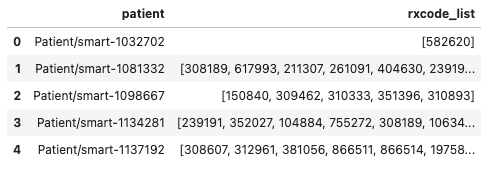

Hint: to accomplish this try modifying the groupby function to merge our drugs by patient, and then apply a lambda function, to append the code values to a list.


📘[Review Pandas groupby() documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)

 🖐 Fill in the appropriate columns to create a list of RxNorm Codes for each patient.

In [ ]:
# HINT: What column do we want to group by? and which column values do we want as a list?
groups_by_patient = rx_df.groupby('FILLMEIN', sort=False)['FILLMEIN'].apply(list)
groups_by_patient = pd.DataFrame({'patient':groups_by_patient.index, 'rxcode_list':groups_by_patient.values})
groups_by_patient.head()

So now we've generated a list of active prescriptions for each patient, we can append this list to the RXNav query and determine whether each of these patients have a drug interaction.

## Step 4: Loop through our entire cohort and determine each patient's drug interactions

To recap: we now have a list of patients with associated drug codes in list form, and we know how to query the RXNav API to determine if a drug interaction exists. 

As a last step, create a series of functions to iterate through our patient list and for each patient return whether or not a Drug on Drug interaction could occur.

It might help to compose a helper function for taking a string of RXCodes (e.g., `123456+654321`) and submit it to the API, and returns the result as a formatted JSON. 

Test our original two drug combinations to ensure that it is outputting the expected responses.

In [ ]:
# Function for calling NIH API
def has_drug_interaction(drug_list):
    drugs = "+".join(drug_list)
    try:
        url = 'https://rxnav.nlm.nih.gov/REST/interaction/list.json?rxcuis=' + drugs
        response = s.get(url, headers={'accept': 'application/json'})
        response_json = response.json()
        return 'fullInteractionTypeGroup' in response_json
    except Exception as e:
        raise e

For this step you'll want to apply this method to each patient's list of RxNorm codes to detect a drug interaction.

While you can choose how you want to format this, here is one possible output format you may want to build towards:

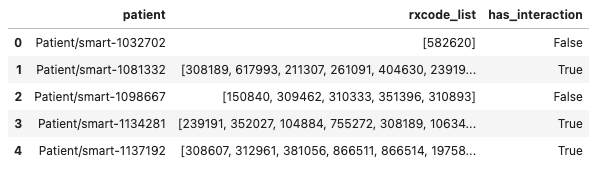

 🖐 Hint look how we used `apply` and `map` previously in Step 3. You could also use a `for` loop and `print` statements if you prefer.

As a bonus consider some additional information you can output, such as keeping a running count of total interactions, or specific details about the interaction types.

## Summary

This exercise demonstrates how FHIR data can interact with the broader ecosystem of healthcare data and resources to determine additional health care insights. Here we pulled data from multiple resources into a unified dataframe, and then modified how the data was stored in order to pass it through to a third-party API and determine health outcomes.